## やりたいこと

[前回の結果](url:http://localhost:8888/notebooks/OneDrive/python/proto2020/開発日誌/AEscript.py‗20200425.ipynb)より、学習率とαのレンジを下側に絞り込んで2度目のグリッドサーチを実施

In [1]:
#%%
# cording = UTF-8
import os,re,random,copy
import scipy,librosa
import numpy as np
import pandas as pd             #ほとんど使わんけど
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import sklearn

####################################初期化####################################
aug_amount = 100        #ファイルごとのAugmentationの回数
lr = 1e-04               #初期学習率
alpha = 1e-06           #L2正則化の係数
dr_rate = 0.2           #ドロップアウト率
batch_size = 50         #オフライン学習時のバッチサイズ
epochs = 100            #学習時のエポック数(グリッドサーチ時は無効)
monitor = "val_loss"    #学習率減衰/早期打ち切りの指標
encode_dim = 500        #オートエンコーダの圧縮次元
n_components = 0.999    #疑似AEの保持分散

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")
ok_dir = os.path.join(data_dir,"OK")
ng_dir = os.path.join(data_dir,"NG")
env_dir = os.path.join(data_dir,"environment")
log_dir = "./logs"       #Tensorboardログの保存パス
modeldir = "./models"   #学習済みモデルの保存パス

#学習用データファイル
datafile = "dataset2.npz"

####################################関数定義###################################

#対象ディレクトリのファイル一覧を取得
def get_file_list(dir):
    path = dir
    file_list = os.listdir(path)
    print("get file_list :{}".format(file_list))
    return file_list

#対象ディレクトリの最大ファイルをサーチ
def wav_search(dir,f_list):
    #呼び出されるごとに初期化する
    wave_list = []
    file_size = 0
    
    return_path = os.path.abspath('./')
    
    os.chdir(dir)
    for i in f_list:
        search_index = re.search('.wav',i)
        if search_index:
            wave_list .append(i)
            if os.path.getsize(i) > file_size:
                file_size = os.path.getsize(i)
                largest_file = i
        
    os.chdir(return_path)   #カレントディレクトリを戻す
    print("get file :{0} ,file size:{1}"\
        .format(largest_file,file_size))
    return wave_list,largest_file,file_size

#オーディオファイルの読み込み サンプルレート22.05kHz、モノラルで固定
def load_wav(dir,file):
    #呼び出されるごとに初期化する
    wf = np.arange(0)

    f_path = os.path.join(dir,file)
    wf,sp_rate = librosa.load(f_path,sr=22050,mono = True)
    del sp_rate
    return wf

#スペクトログラムの取得 パワースペクトラムのまま処理するならlibrosa不要
def get_spg(wf):
    spg = np.arange(0)
    sp_f,sp_t,spg = scipy.signal.spectrogram(wf,fs=22050,
        window = np.hamming(1024),nfft =1024)
#    spg = librosa.power_to_db(spg)
    spg =spg.astype('float16')
    return sp_f,sp_t,spg

#Augmentationの処理
def aug_process(frame,dir,wave_list,env_file,):
    #呼び出されるごとに初期化する
    length = 0
    count = 0
    wf = np.arange(0)

    length = int(frame * 1.2)
    for i in wave_list:
        wf = load_wav(dir,i)
        for j in range(aug_amount):
            start = random.randint(0,len(env_file)-length)
            aug_wav = copy.deepcopy(env_file[start : start + length])
            del start
            start = random.randint(0,len(aug_wav) - len(wf))
            aug_wav = aug_wav + random.gauss(1,0.05)
            aug_wav[ start:start + len(wf) ] = \
                aug_wav[ start : start + len(wf) ] + wf
            sp_f,sp_t,spg = get_spg(aug_wav)
            spg = spg.reshape(1,len(sp_f),len(sp_t))
            try:
                X_data
            except:
                X_data = copy.deepcopy(spg)
            else:
                X_data = np.vstack((X_data,spg))
            del start,aug_wav,sp_f,sp_t,spg
            count = count + 1
        del wf
        print("Augmentation done! total count = {}".format(count))

    return X_data

#データセットの作成 ここまでの関数は全部ここに集約される
#最大ファイルサイズに合わせてフレームサイズを定義し
#OK・NG各データセットを作成後、結合する

def new_dataset(aug,ok_dir,ng_dir,env_dir):
    #OKNGそれぞれのファイルリストと最大ファイルを取得
    ok_filelist = get_file_list(ok_dir)
    ok_wave_list,ok_largeest_name,ok_largest_size = wav_search(ok_dir,ok_filelist)
    ng_filelist = get_file_list(ng_dir)
    ng_wave_list,ng_largeest_name,ng_largest_size = wav_search(ng_dir,ng_filelist)

    #OKNGの最大を比較
    if ok_largest_size>ng_largest_size:
        largest_dir = ok_dir
        lergest_name = ok_largeest_name
        print("largetst:OK")
    else:
        largest_dir = ng_dir
        lergest_name = ng_largeest_name
        print("largetst:NG")

    #最大フレームサイズを取得
    wf = load_wav(largest_dir,lergest_name)
    frame = int(len(wf))
    #wf = np.insert(wf,frame,np.empty(int(frame*0.2))) #1.2倍する
    #sp_f,sp_t,spg = get_spg(wf) 
    #X_initsize = (len(sp_f),len(sp_t))
    #del wf,sp_f,sp_t,spg
    del wf

    #環境音データをロード
    env_data = load_wav(env_dir,"env.wav")
    
    #OKデータセット作成
    X_ok = copy.deepcopy(
        aug_process(frame,ok_dir,ok_wave_list,env_data)
        )
    y_ok = np.zeros(len(X_ok),dtype = 'bool')   #OKデータをfalse(陰性)と定義

    #NGデータセット作成
    X_ng = copy.deepcopy(
        aug_process(frame,ng_dir,ng_wave_list,env_data)
        )
    y_ng = np.ones(len(X_ng),dtype = 'bool')    #NGデータをTrue(陽性)と定義

    #データセットの結合
    X_data = np.vstack((X_ok,X_ng))
    y_data = np.append(y_ok,y_ng)
    del X_ok,y_ok,X_ng,y_ng

    return X_data,y_data

#OKNGが混在したデータからFalseのみを分離する
def mixed_to_sprit(X_mixed,y_mixed):
    #呼び出されるごとに初期化する
    try:
        X_sprit
    except:
        pass    #X_spritが存在しなければ何もしない
    else:
        del X_sprit #前のデータを消去する

    #y_mixedをboolianindexと見なし、論理値を反転してX_mixedから抽出
    X_sprit = X_mixed[np.logical_not(y_mixed)]

    return X_sprit

###################################メイン処理###################################

#データセット読み込み なければ作る
if os.path.exists(os.path.join(data_dir,datafile)) == False:
    X_data,y_data = new_dataset(aug_amount,ok_dir,ng_dir,env_dir)
    np.savez_compressed(os.path.join(data_dir,datafile),
        X = X_data,y = y_data)
    print("Data set saved!") #ファイルネーム表示機能つけること
else:
    load_data = np.load(os.path.join(data_dir,datafile))
    X_data =load_data['X']
    y_data = load_data['y']
    del load_data
    print("Data loaded!!")

X_shape = X_data.shape[1:]  #データの形状を取得


Data loaded!!


In [2]:
#データ前処理 trainとtestを分離
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = \
    train_test_split(
        X_data.reshape(len(X_data),-1), #アフィン変換
        y_data,
        test_size=0.05)
print(
"Training data amounts :{0}\n\
Test data amounts :{1}"\
.format(len(y_train),len(y_test))
)
del X_data,y_data


Training data amounts :3800
Test data amounts :200


In [3]:
#X_trainからOKデータ(False)だけを抽出する
X_train_ae = mixed_to_sprit(X_train,y_train)
print(
"X_train for Autoencoder was splited!!\n\
amount/shape:{0}"
.format(X_train_ae.shape)
)

X_train for Autoencoder was splited!!
amount/shape:(1901, 60021)


In [4]:
#オートエンコーダの定義

from keras.models import Model,Sequential
from keras.layers import Input, Dense,Dropout,Activation
from keras.layers.normalization import BatchNormalization
from keras import regularizers

#Functionalでの実装
def ae(input_dim,encode_dim,lr,alpha,dr_rate):

    input_data = Input(shape = (input_dim,))

    #エンコーダを定義
    encoder = Dense(
        encode_dim,
        kernel_initializer="he_normal",
        kernel_regularizer=regularizers.l2(alpha),
        )(input_data)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(dr_rate)(encoder)
    encoder = Activation("relu")(encoder)

    #デコーダを定義 こっちにはドロップアウトは定義しない
    decoder = Dense(input_dim,kernel_initializer="he_normal")(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Activation("sigmoid")(decoder)

    #モデルを定義
    autoencoder = Model(input = input_data,output = decoder)

    #最適化関数
    opt = keras.optimizers.Nadam(lr = lr)

    autoencoder.compile(
        optimizer = opt,loss='binary_crossentropy',metrics=['accuracy']
        )

    return autoencoder

#コールバック定義 早期打ち切り
def cb_es(monitor):
    x = keras.callbacks.EarlyStopping(monitor = monitor,patience=5)
    return x

Using TensorFlow backend.


9ms/step - loss: 0.6929 - accuracy: 0.3030
Epoch 12/20
1267/1267 [==============================] - 34s 27ms/step - loss: 0.6929 - accuracy: 0.3178
Epoch 13/20
1267/1267 [==============================] - 37s 29ms/step - loss: 0.6929 - accuracy: 0.3304
Epoch 14/20
1267/1267 [==============================] - 37s 29ms/step - loss: 0.6929 - accuracy: 0.3418
Epoch 15/20
1267/1267 [==============================] - 35s 27ms/step - loss: 0.6929 - accuracy: 0.3500
Epoch 16/20
1267/1267 [==============================] - 39s 31ms/step - loss: 0.6928 - accuracy: 0.3571
Epoch 17/20
1267/1267 [==============================] - 35s 28ms/step - loss: 0.6928 - accuracy: 0.3635
Epoch 18/20
1267/1267 [==============================] - 36s 29ms/step - loss: 0.6928 - accuracy: 0.3681
Epoch 19/20
1267/1267 [==============================] - 37s 29ms/step - loss: 0.6928 - accuracy: 0.3723
Epoch 20/20
1267/1267 [==============================] - 8s 6ms/step
[CV]  alpha=1e-08, batch_size=50, dr_rate=0.2, e

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_batch_size,param_dr_rate,param_epochs,param_lr,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,866.953846,13.929680,4.601265,0.100720,0.0001,50,0.2,20,0.0001,"{'alpha': 0.0001, 'batch_size': 50, 'dr_rate':...",...,0.400262,0.400843,0.402403,0.002627,11,0.400552,0.403475,0.403182,0.402403,0.001314
1,853.199671,7.522220,4.531580,0.164541,0.0001,50,0.2,20,1e-05,"{'alpha': 0.0001, 'batch_size': 50, 'dr_rate':...",...,0.400262,0.400843,0.402403,0.002627,11,0.400552,0.403475,0.403182,0.402403,0.001314
2,862.424609,1.290620,4.926532,0.494227,0.0001,50,0.2,20,1e-06,"{'alpha': 0.0001, 'batch_size': 50, 'dr_rate':...",...,0.400262,0.400843,0.402403,0.002627,11,0.400552,0.403475,0.403182,0.402403,0.001314
3,837.416356,4.081714,4.506898,0.059490,0.0001,50,0.2,20,1e-07,"{'alpha': 0.0001, 'batch_size': 50, 'dr_rate':...",...,0.488135,0.488730,0.488959,0.000783,8,0.489399,0.488541,0.488962,0.488967,0.000350
4,844.213040,12.087091,5.309449,0.628447,0.0001,50,0.2,20,1e-08,"{'alpha': 0.0001, 'batch_size': 50, 'dr_rate':...",...,0.499085,0.498948,0.499132,0.000172,4,0.499469,0.499075,0.498899,0.499147,0.000238
5,835.700478,6.385338,5.329854,0.730887,1e-05,50,0.2,20,0.0001,"{'alpha': 1e-05, 'batch_size': 50, 'dr_rate': ...",...,0.400262,0.400843,0.402403,0.002627,11,0.400552,0.403475,0.403182,0.402403,0.001314
6,834.131040,5.273331,4.796819,0.373657,1e-05,50,0.2,20,1e-05,"{'alpha': 1e-05, 'batch_size': 50, 'dr_rate': ...",...,0.400262,0.400843,0.402403,0.002627,11,0.400552,0.403475,0.403182,0.402403,0.001314
7,826.588150,8.052902,4.781098,0.192242,1e-05,50,0.2,20,1e-06,"{'alpha': 1e-05, 'batch_size': 50, 'dr_rate': ...",...,0.400262,0.400843,0.402403,0.002627,11,0.400552,0.403475,0.403182,0.402403,0.001314
8,822.564450,8.912559,4.536343,0.036102,1e-05,50,0.2,20,1e-07,"{'alpha': 1e-05, 'batch_size': 50, 'dr_rate': ...",...,0.488118,0.486666,0.487637,0.000687,10,0.487652,0.488624,0.486738,0.487672,0.000770
9,824.500277,2.922887,4.913274,0.432193,1e-05,50,0.2,20,1e-08,"{'alpha': 1e-05, 'batch_size': 50, 'dr_rate': ...",...,0.499693,0.499109,0.499292,0.000284,2,0.499013,0.499822,0.499242,0.499359,0.000340


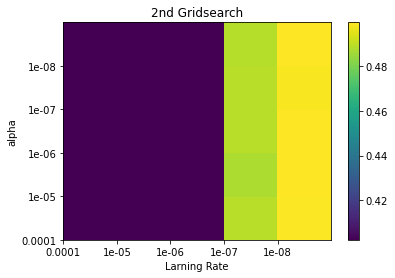

In [5]:
# パラメータ空間の定義
def gs_param():
    pm = {
        'alpha' : [1e-04,1e-05,1e-06,1e-07,1e-08],
        'lr':[1e-04,1e-05,1e-06,1e-07,1e-08],
        'dr_rate':[0.2],
        'batch_size':[50],
        'epochs':[20]
    }
    return pm

#SklearnでラップしたAEを生成
from keras.wrappers.scikit_learn import KerasClassifier
ae_sklearn = KerasClassifier(
    build_fn = ae,
    input_dim = X_train_ae.shape[1],
    encode_dim = encode_dim,
    lr = lr,
    alpha = alpha,
    dr_rate = dr_rate
)

#グリッドサーチ
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(
    estimator = ae_sklearn,
    param_grid = gs_param(),
    return_train_score = True,
    cv = 3,
    verbose = 2 
)
grid.fit(X_train_ae,X_train_ae)

#レポートの表示
print('Gridsearch is over!')
print("Best parameters :{}".format(grid.best_params_))
print("Best cross-validation score :{}".format(grid.best_score_))

#テスト結果の一覧表示(データフレーム使用)
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
display(results)

#ヒートマップ描画
pm = gs_param()
npresult = np.array(grid.cv_results_['mean_test_score']).reshape(5,5)
plt.pcolormesh(npresult)
plt.title('2nd Gridsearch')
plt.ylabel("alpha")
plt.yticks(np.arange(len(pm['alpha'])),pm['alpha'])
plt.xlabel("Larning Rate")
plt.xticks(np.arange(len(pm['lr'])),pm['lr'])
plt.colorbar()
plt.show()

ほぼ予想通りの結果。
```Python:result
Best parameters :{'alpha': 1e-06, 'batch_size': 50, 'dr_rate': 0.2, 'epochs': 20, 'lr': 1e-08}
Best cross-validation score :0.4995509584744771
```
上位10個を抽出すると…

|No|param_alpha|param_lr|mean_test_score|std_test_score|rank_test_score|mean_train_score|std_train_score|
|---|---|---|---|---|---|---|---|
|14|1.00E-06|1.00E-08|0.499551|0.000421|1|0.499516|0.000487|
|9|1.00E-05|1.00E-08|0.499292|0.000284|2|0.499359|0.00034|
|24|1.00E-08|1.00E-08|0.49927|0.000699|3|0.499239|0.000771|
|4|0.0001|1.00E-08|0.499132|0.000172|4|0.499147|0.000238|
|19|1.00E-07|1.00E-08|0.498788|0.000341|5|0.498789|0.00035|
|13|1.00E-06|1.00E-07|0.489236|0.000841|6|0.48925|0.000734|
|18|1.00E-07|1.00E-07|0.489047|0.000155|7|0.489064|0.000516|
|3|0.0001|1.00E-07|0.488959|0.000783|8|0.488967|0.00035|
|23|1.00E-08|1.00E-07|0.488884|0.00069|9|0.488754|0.000526|
|8|1.00E-05|1.00E-07|0.487637|0.000687|10|0.487672|0.00077|

alphaはこれまでの検証結果にほぼ従い、1e-06が最良の結果になっている  
[alphaの効果検証結果](url:http://localhost:8888/notebooks/OneDrive/python/proto2020/開発日誌/AEscript.py‗20200425_2.ipynb) →accuracyの悪化要因にしかなってないのでL2正規化は不要  

lrは低いほど高い精度が出ているが… Lossの傾向はどうだろう？ →[検証結果](URL:http://localhost:8888/notebooks/OneDrive/python/proto2020/開発日誌/AEscript.py‗20200426_2.ipynb)

次回グリッドサーチ候補

```python:next_param
        'alpha' : [1e-05,5e-06,1e-06,5e-07,1e-07],
        'lr':[1e-05,1e-06,1e-07,1e-08,1e-09],

```